Probability this interval is net pay (≥60% sand): 100.0%


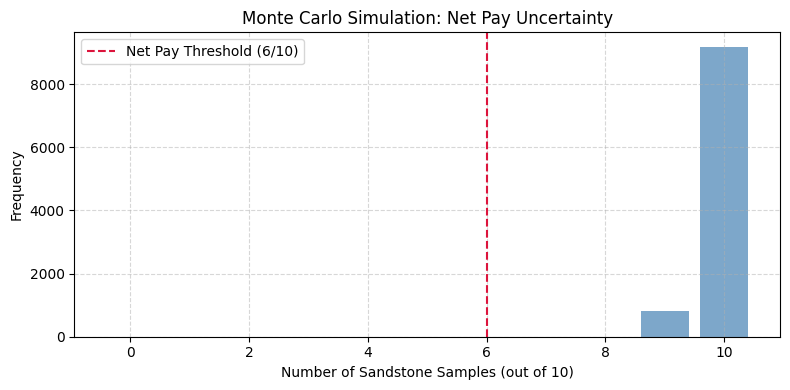

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# --- Step 1: Train classifier on labeled data ---
np.random.seed(2025)
n = 300
gr = np.random.exponential(50, n) + np.random.normal(0, 10, n)
resistivity = np.where(gr < 60,
                      np.random.normal(20, 5, n),
                      np.random.normal(5, 2, n))

# True lithology: low GR + high resistivity = sand
litho = np.where((gr < 60) & (resistivity > 10), 'Sandstone', 'Shale')

# Train probabilistic classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(np.column_stack((gr, resistivity)), litho)

# --- Step 2: Predict probabilities for a new interval ---
# Assume we have 10 log samples in a new zone
gr_new = np.array([45, 50, 55, 48, 52, 60, 58, 53, 49, 51])
res_new = np.array([18, 22, 19, 21, 20, 12, 14, 17, 23, 20])
X_new = np.column_stack((gr_new, res_new))

# Get class probabilities
probs = clf.predict_proba(X_new)  # Shape: (10, 2)
sand_probs = probs[:, clf.classes_ == 'Sandstone'].flatten()

# --- Step 3: Monte Carlo – simulate lithology 10,000 times ---
n_sims = 10_000
net_pay_counts = []

for _ in range(n_sims):
    # For each sample, randomly assign lithology based on probability
    is_sand = np.random.rand(10) < sand_probs
    net_pay_counts.append(np.sum(is_sand))  # Count net pay samples

net_pay_counts = np.array(net_pay_counts)
net_pay_prob = np.mean(net_pay_counts >= 6)  # >60% sand = net pay zone

print(f"Probability this interval is net pay (≥60% sand): {net_pay_prob*100:.1f}%")

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(net_pay_counts, bins=np.arange(-0.5, 11, 1), color='steelblue', alpha=0.7, rwidth=0.8)
plt.axvline(6, color='crimson', linestyle='--', label='Net Pay Threshold (6/10)')
plt.xlabel('Number of Sandstone Samples (out of 10)')
plt.ylabel('Frequency')
plt.title('Monte Carlo Simulation: Net Pay Uncertainty')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig('mc_ml_lithology.png', dpi=300, bbox_inches='tight')
plt.show()